# Classification with a homogenous static MLP model

### env management

In [1]:
%env "WANDB_NOTEBOOK_NAME" "homo_classification_deterministic_growth.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="homo_classification_deterministic_growth.ipynb"
env: WANDB_SILENT=True


### imports and setup

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot


import os
import sys
import time
import logging

In [3]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='vlag', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
# mplstyle.use('fast')

In [4]:
class MidpointNormalize(Normalize):
    """
    Normalize and shift the colormap to center 0
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin, vmax, midpoint) = self.vmin, self.vmax, self.midpoint
        if vmin is None or vmax is None:
            vmin, vmax = np.min(value), np.max(value)
        if midpoint is None:
            midpoint = (vmin + vmax) / 2
        result = np.ma.masked_array(np.interp(value, [vmin, midpoint, vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

### config

In [5]:
jax.config.update('jax_platform_name', 'cpu')

In [6]:
input_size = 2
hidden_sizes = [32, 32] 
min_neurons = 64
output_size = 10
max_neurons = 64
initial_activation_list = [jax.nn.tanh]
activation_list = [jax.nn.tanh]
# last_activation = jax.nn.sigmoid
optimizer = optax.adabelief
bias = False
num_epochs = 20000
intervene_every = 200
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

act_string = "_".join([act.__name__ for act in initial_activation_list])

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                # last_activation=last_activation,
                seed=seed)

In [7]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'intervene_every': intervene_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [8]:
# jax.config.update("jax_enable_x64", True)

Description = f"Homo_{act_string}_spiral_static_{optimizer.__name__}_no_bias_{max_neurons}_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{seed}"
fig_folder = f"../figures/single_run/{Description}"
out_folder = f"../output/single_run/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

### logging

In [9]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 1
Description: Homo_tanh_spiral_static_adabelief_no_bias_64_32_32_20000_0
jax backend: cpu
jax devices: [CpuDevice(id=0)]


### data

In [10]:
def create_spiral_dataset(key, n_samples, num_classes):
    """
    Create a multi-class 2D spiral dataset.

    Parameters:
    - key: JAX random key.
    - n_samples: Dataset size
    - num_classes: Number of spiral arms/classes.

    Returns:
    - points: The dataset points.
    - labels: The labels for each point.
    """
    points = []
    labels = []
    points_per_class = n_samples // num_classes
    for class_idx in range(num_classes):
        # Adjust the random key for each class
        key, subkey = jax.random.split(key)
        # Generate radii and angles for the current class
        radii = jnp.linspace(0.0, 1, points_per_class) * 5
        angles = jnp.linspace(class_idx * 4, (class_idx + 1) * 4, points_per_class) + jax.random.normal(subkey, (points_per_class,)) * 0.2
        # Convert polar to Cartesian
        x = radii * jnp.sin(angles)
        y = radii * jnp.cos(angles)
        class_points = jnp.column_stack((x, y))
        points.append(class_points)
        labels.append(jnp.full(points_per_class, class_idx))
    # Concatenate all class points and labels
    points = jnp.vstack(points)
    labels = jnp.hstack(labels)
    return points, labels

x, labels = create_spiral_dataset(key, n_samples, output_size)

In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))
x_scaled = scaler.fit_transform(x)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, labels, test_size=0.2, random_state=seed)


In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16000, 2), (16000,), (4000, 2), (4000,))

In [14]:
y_train.std()

Array(2.8731248, dtype=float32)

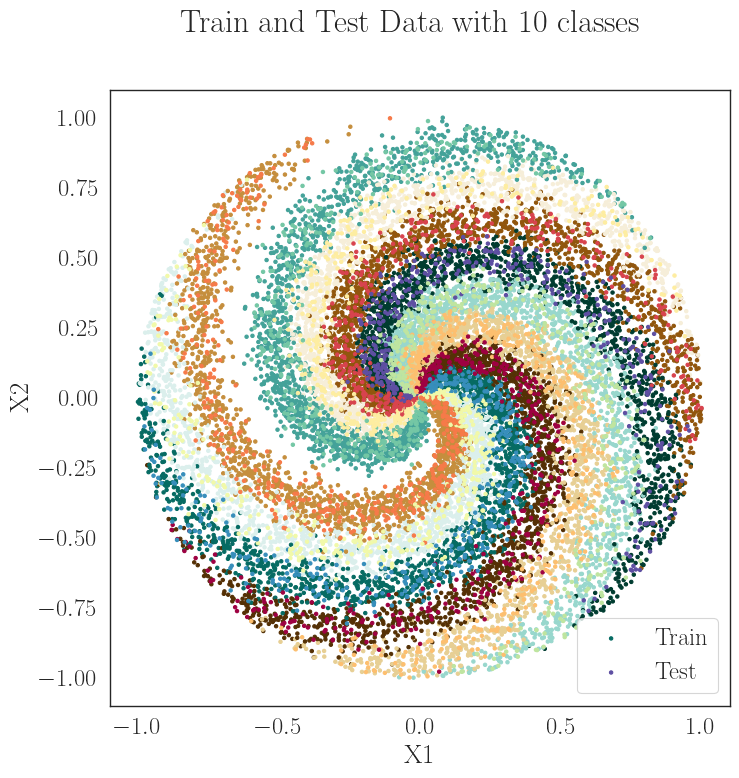

In [15]:
# plot train and test data  on the same plot

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='BrBG', marker='.', label='Train')
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='Spectral', marker='.', label='Test')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.suptitle(f'Train and Test Data with {len(np.unique(y_train))} classes')
ax.legend()
plt.savefig(f"{fig_folder}/train_test_data.png")
plt.savefig(f"{fig_folder}/train_test_data.pdf")
plt.savefig(f"{fig_folder}/train_test_data.svg", format='svg', bbox_inches='tight')


### training and eval scheme

In [16]:
def initialize_optimizer_state(mlp, optimizer):
    """
    Optimizer initialization that filters for float arrays in the jax pytrees
    """
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [17]:
@jax.jit
def cross_entropy(y, pred_y):
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

In [18]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred_y = jax.nn.log_softmax(jax.vmap(mlp)(x))
    loss = cross_entropy(y, pred_y)
    return loss

In [19]:
@eqx.filter_jit()
def accuracy(mlp, x, y):
    logits = jax.vmap(mlp)(x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

In [20]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [21]:
@eqx.filter_jit()
def test_step(mlp, x, y):
    return compute_loss(mlp, x, y)[0], accuracy(mlp, x, y)

In [22]:
@eqx.filter_jit()
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

### initializing MLP

In [23]:
mlp = CustomMLP(config)
init_neurons = sum(mlp.get_shape())
logging.info(f"Number of neurons at start: {init_neurons}")

Number of neurons at start: 74


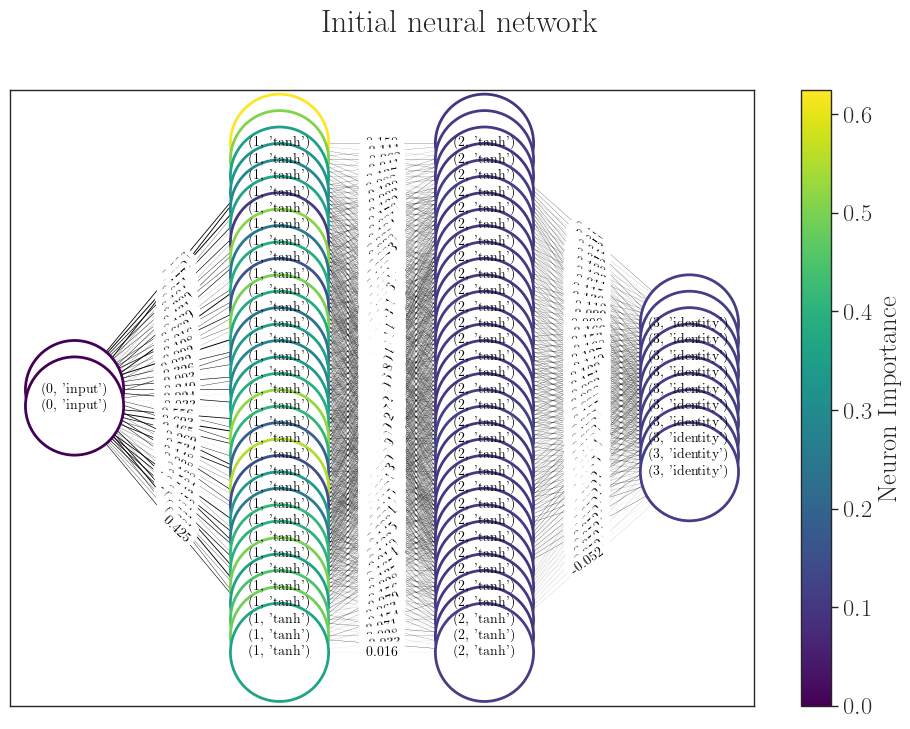

In [24]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Initial neural network")
plt.savefig(f"{fig_folder}/initial_graph.png")
plt.savefig(f"{fig_folder}/initial_graph.pdf")
plt.savefig(f"{fig_folder}/initial_graph.svg", format='svg', bbox_inches='tight')

In [25]:
initial_adjacency_matrix = mlp.adjacency_matrix()

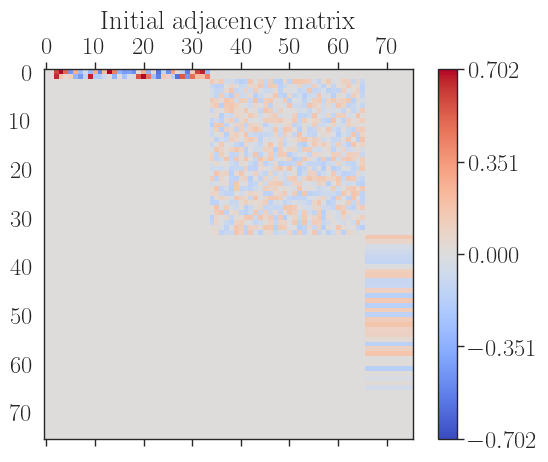

In [26]:
max_wt = np.max(np.abs(initial_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(initial_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.svg", format='svg', bbox_inches='tight')

### initializing optimizer

In [27]:
opt = optimizer(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

### training

In [28]:
train_loss_history = []
test_loss_history = []
accuracy_history = []
node_history = []
grad_norm_history = []
graph_history = []
update_history = []


In [29]:
for epoch in range(num_epochs):

    train_loss, mlp, opt_state = train_step(mlp, x_train, y_train, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x_train, y_train)
    grad_norm_val = grad_norm(grads)
    n_neurons = sum(mlp.get_shape()) - output_size

    logging.info(f"Epoch {epoch :03d}, Loss: {train_loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val :.3e}")
    train_loss_history.append((epoch, train_loss))
    grad_norm_history.append((epoch,grad_norm_val))
    node_history.append((epoch, n_neurons))

    key, add_key, sub_key, prob_key = jax.random.split(key,4)

    if (epoch + 1) % intervene_every == 0 and epoch!=num_epochs-1:
        test_loss, test_accuracy = test_step(mlp, x_test, y_test)
        logging.info(f"Epoch {epoch :03d}, Test loss: {test_loss.item()}, Test accuracy: {test_accuracy}")
        test_loss_history.append((epoch,test_loss))
        accuracy_history.append((epoch, test_accuracy))




Epoch 000, Loss: 2.3025851249694824, Neurons: 64, Grad norm: 1.180e-01
Epoch 001, Loss: 2.3020641803741455, Neurons: 64, Grad norm: 1.187e-01
Epoch 002, Loss: 2.3015074729919434, Neurons: 64, Grad norm: 1.195e-01
Epoch 003, Loss: 2.300912380218506, Neurons: 64, Grad norm: 1.205e-01
Epoch 004, Loss: 2.300276517868042, Neurons: 64, Grad norm: 1.215e-01
Epoch 005, Loss: 2.2995972633361816, Neurons: 64, Grad norm: 1.225e-01
Epoch 006, Loss: 2.298872232437134, Neurons: 64, Grad norm: 1.237e-01
Epoch 007, Loss: 2.2980988025665283, Neurons: 64, Grad norm: 1.249e-01
Epoch 008, Loss: 2.297274589538574, Neurons: 64, Grad norm: 1.261e-01
Epoch 009, Loss: 2.296396493911743, Neurons: 64, Grad norm: 1.275e-01
Epoch 010, Loss: 2.295461893081665, Neurons: 64, Grad norm: 1.288e-01
Epoch 011, Loss: 2.2944674491882324, Neurons: 64, Grad norm: 1.303e-01
Epoch 012, Loss: 2.293409585952759, Neurons: 64, Grad norm: 1.318e-01
Epoch 013, Loss: 2.292285442352295, Neurons: 64, Grad norm: 1.334e-01
Epoch 014, Los

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", node_history)
np.savetxt(f"{out_folder}/train_loss.txt", train_loss_history)
np.savetxt(f"{out_folder}/test_loss.txt", test_loss_history)
np.savetxt(f"{out_folder}/test_accuracy.txt", accuracy_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

In [ ]:
# save the update history
with open(f"{out_folder}/update_history.txt", "w") as f:
    for item in update_history:
        f.write(f"{item}\n")


### evaluation

In [ ]:
y_test

Array([9, 2, 8, ..., 4, 7, 4], dtype=int32, weak_type=True)

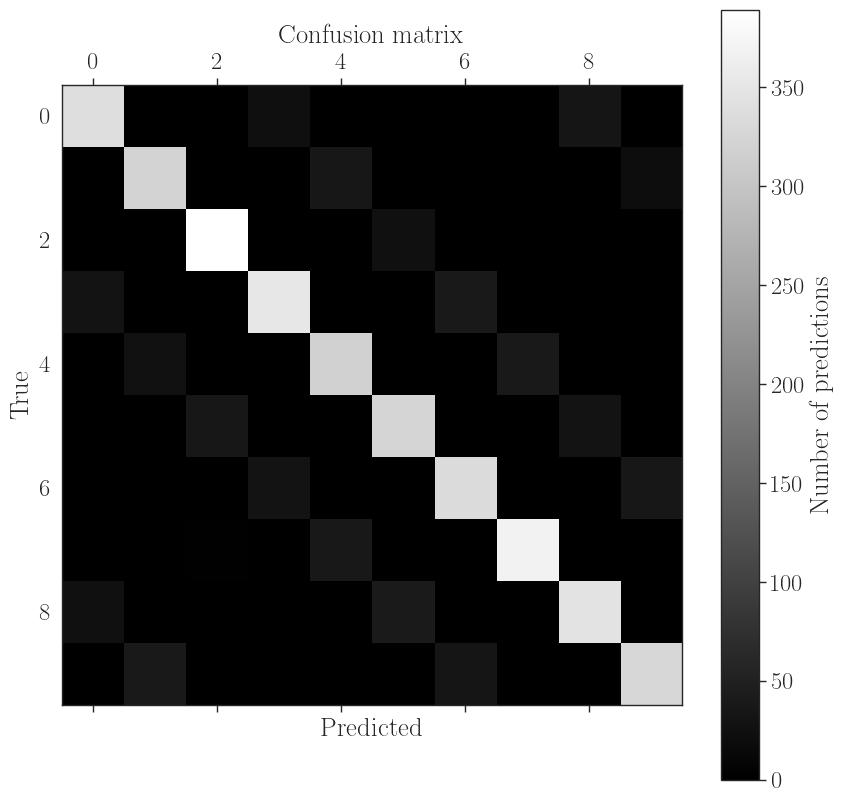

In [ ]:
y_pred = jax.nn.softmax(jax.vmap(mlp)(x_test))
y_pred = np.argmax(y_pred, axis=-1)
n_classses = len(np.unique(y_test))
confusion_matrix = np.zeros((n_classses, n_classses))
for true, pred in zip(y_test, y_pred):
    confusion_matrix[true, pred] += 1

np.savetxt(f"{out_folder}/confusion_matrix.txt", confusion_matrix)
fig, ax = plt.subplots(figsize=[10,10])
cax = ax.matshow(confusion_matrix, cmap='gray')
fig.colorbar(cax, label="Number of predictions")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.savefig(f"{fig_folder}/confusion_matrix.png")
plt.savefig(f"{fig_folder}/confusion_matrix.pdf")
plt.savefig(f"{fig_folder}/confusion_matrix.svg", format='svg', bbox_inches='tight')


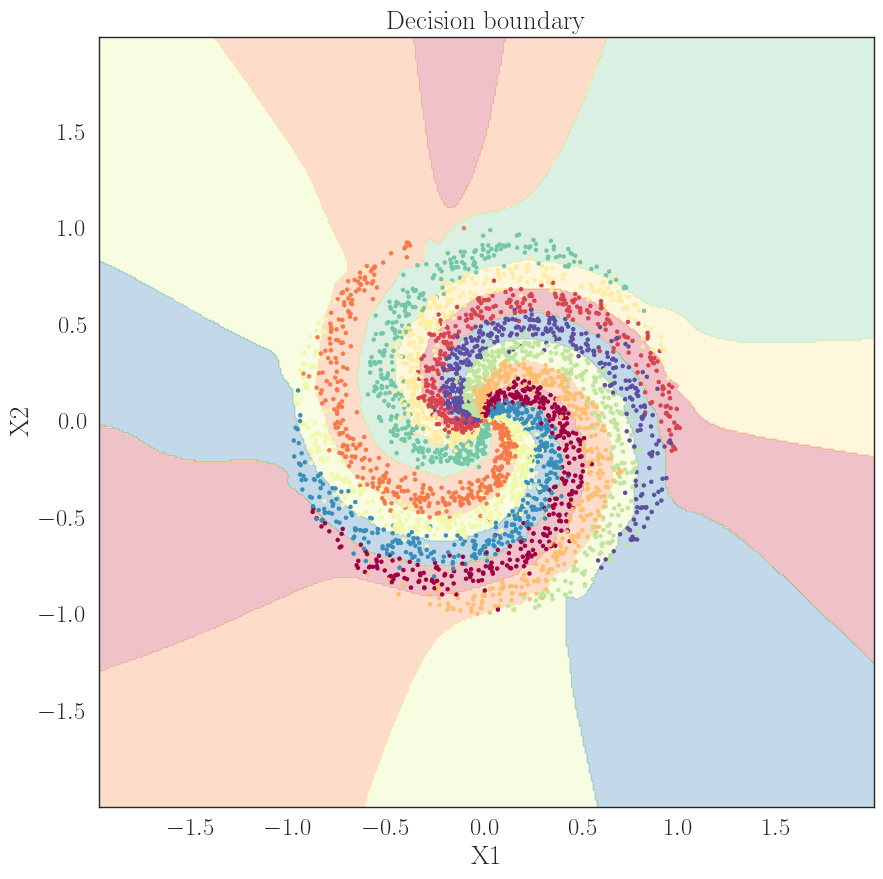

In [ ]:
# plot decision boundary
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                    np.arange(y_min, y_max, 0.01))

Z = jax.nn.softmax(jax.vmap(mlp)(np.c_[xx.ravel(), yy.ravel()]))
Z = np.argmax(Z, axis=-1)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=[10,10])
ax.contourf(xx, yy, Z, alpha=0.3, cmap='Spectral')
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='Spectral', marker='.')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision boundary")
plt.savefig(f"{fig_folder}/decision_boundary.png")
plt.savefig(f"{fig_folder}/decision_boundary.pdf")
plt.savefig(f"{fig_folder}/decision_boundary.svg", format='svg', bbox_inches='tight')



In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

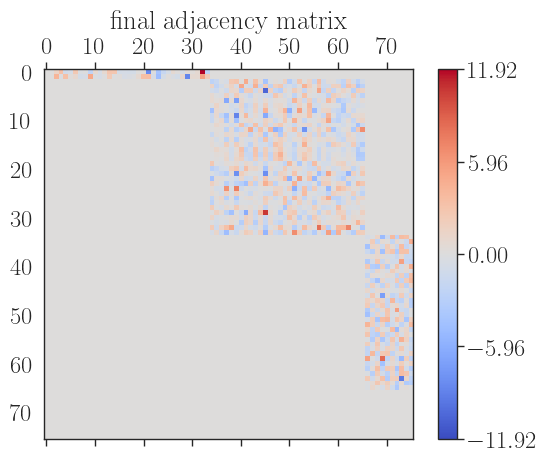

In [ ]:
max_wt = np.max(np.abs(final_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(final_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.svg", format='svg', bbox_inches='tight')

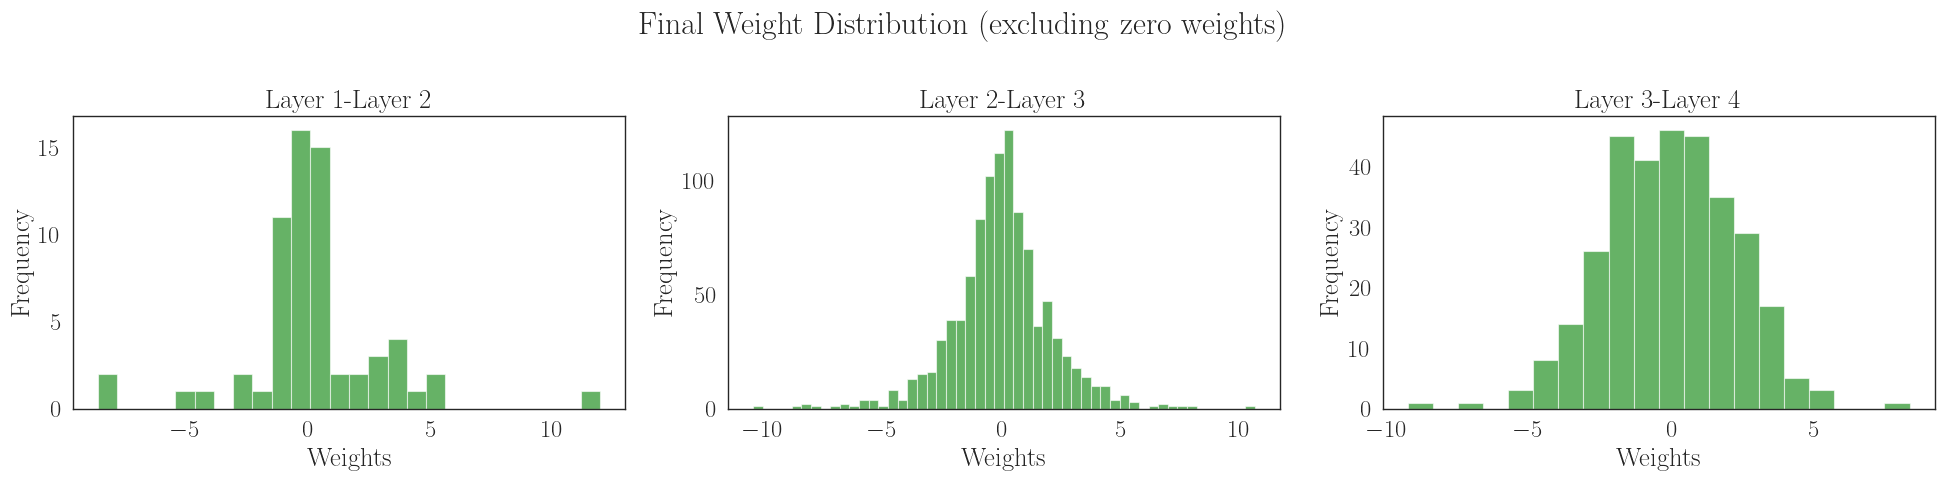

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum([mlp.input_size] + mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')


plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.savefig(f"{fig_folder}/final_weight_distribution.pdf")
plt.savefig(f"{fig_folder}/final_weight_distribution.png")
plt.savefig(f"{fig_folder}/final_weight_distribution.svg", format='svg', bbox_inches='tight')
plt.show()

In [ ]:
train_epochs, train_loss = zip(*train_loss_history)
test_epochs, test_loss = zip(*test_loss_history)
grad_epochs, grad_norm_val = zip(*grad_norm_history)
node_epochs, n_neurons = zip(*node_history)
accuracy_epochs, test_accuracy = zip(*accuracy_history)

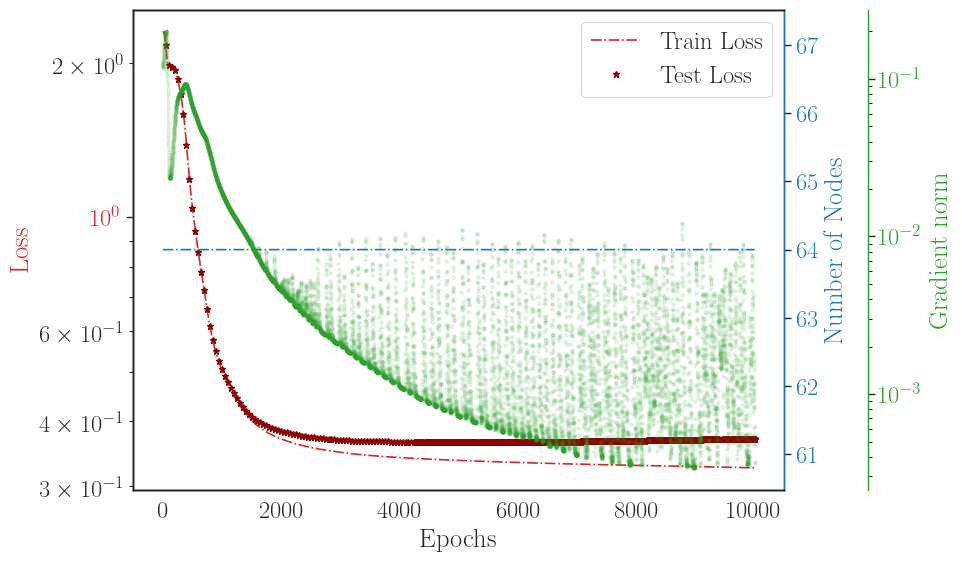

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

# ax1.set_xscale("log")

fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve.png")
plt.savefig(f"{fig_folder}/loss_curve.pdf")
plt.savefig(f"{fig_folder}/loss_curve.svg", format='svg', bbox_inches='tight')

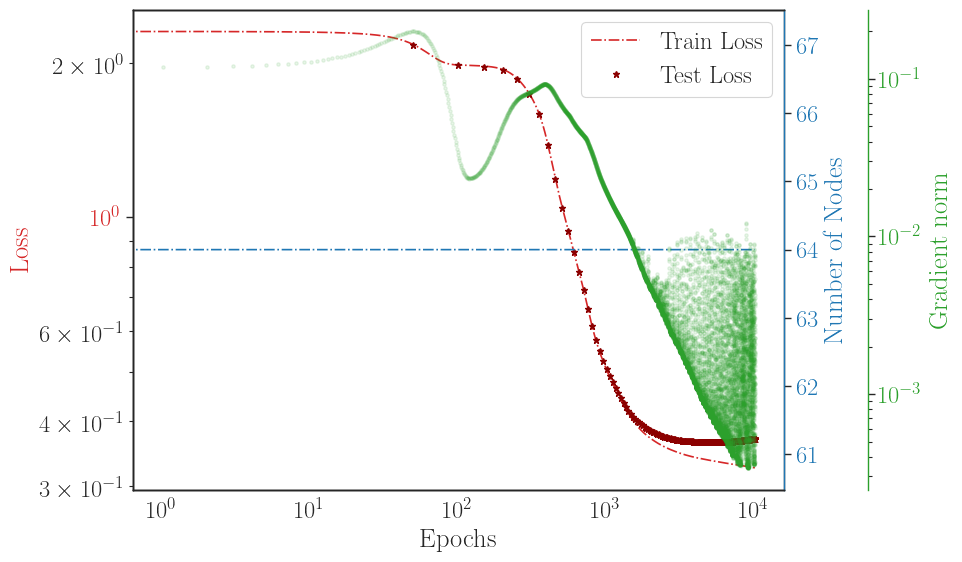

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

ax1.set_xscale("log")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve_loglog.png")
plt.savefig(f"{fig_folder}/loss_curve_loglog.pdf")
plt.savefig(f"{fig_folder}/loss_curve_loglog.svg", format='svg', bbox_inches='tight')

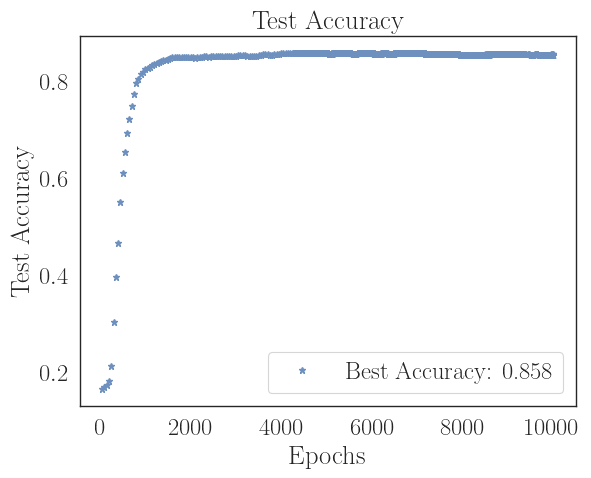

In [ ]:
plt.plot(accuracy_epochs, test_accuracy, "*", label= f"Best Accuracy: {max(test_accuracy) :.3f}")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy")
plt.legend()
plt.savefig(f"{fig_folder}/test_accuracy.png")
plt.savefig(f"{fig_folder}/test_accuracy.pdf")
plt.savefig(f"{fig_folder}/test_accuracy.svg", format='svg', bbox_inches='tight')

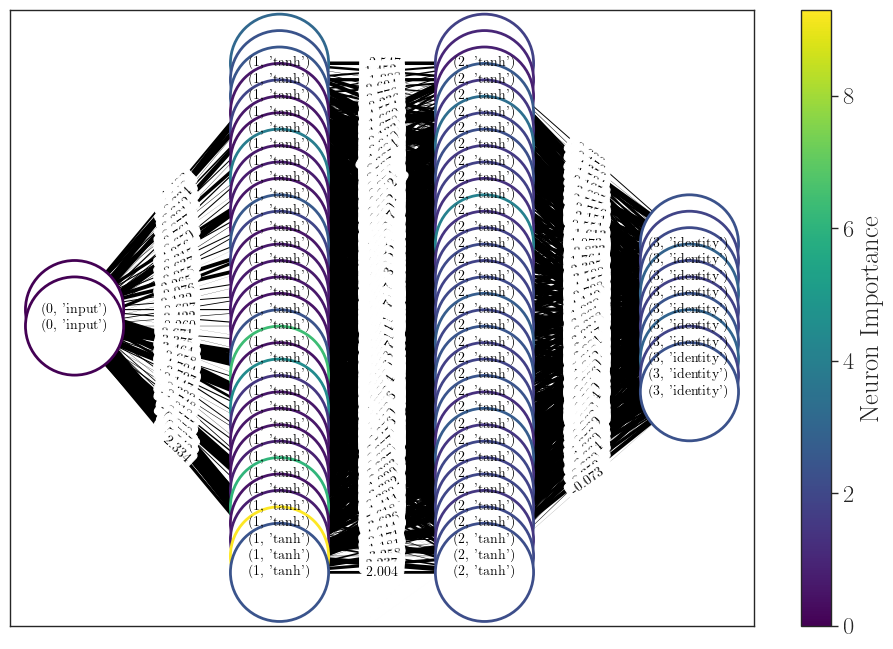

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
plt.savefig(f"{fig_folder}/final_graph.pdf")
plt.savefig(f"{fig_folder}/final_graph.svg", format='svg', bbox_inches='tight')